In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA 
from sklearn.linear_model import LogisticRegression


In [17]:
def regreessBehavior(choiceB,qAs,qBs,seqAB=None):
    idx=(qAs!=0)&(qBs!=0)
    if seqAB is not None:
        X = np.vstack((np.log(qBs[idx]/qAs[idx]),seqAB[idx])).T
    else:
        X = np.log(qBs[idx]/qAs[idx]).reshape(-1,1)
    y = choiceB[idx]
    model = LogisticRegression()
    model.fit(X,y)
    return model
    # return model.intercept_[0], model.coef_[0]


def importAndPreprocess(dirPath,activityFileName):
    import os
    import sys

    
    with np.load(os.path.join(dirPath,activityFileName),allow_pickle=True) as f:
        x = f['x']
        trial_params = f['trial_params']
        model_output = f['model_output']
        model_state = f['model_state']
        mask = f.get('mask', None)
    
    if mask is None:
        temp = np.mean(model_output[:,300:,:],1)
    else: 
        temp = np.mean(mask * model_output,1)
    choiceLR = temp[:,1]>temp[:,0]
    choiceLR = choiceLR*2-1 # pos right high, neg left high
    
    choiceFrame = np.array([trial_params[i]['choiceFrame'] for i in range(len(trial_params))])
    
    
    locAB = [(1 if trial_params[i]['locAB']=='AB' or trial_params[i]['locAB']=='12' else -1) for i in range(len(trial_params))]
    loc12 = locAB
    seqAB = [(1 if trial_params[i]['seqAB']=='AB' else -1) for i in range(len(trial_params))]
    
    choiceAB = np.array([(choiceLR[i] * locAB[i] if choiceFrame[i]=='juice' else choiceLR[i] * locAB[i] * seqAB[i]) for i in range(len(trial_params)) ])  # pos B neg A
    choice12 = np.array([(choiceAB[i] * seqAB[i] if choiceFrame[i]=='juice' else choiceLR[i] * locAB[i]) for i in range(len(trial_params)) ])  # pos 2 neg 1
    choiceB = np.array([1 if choiceAB[i]>0 else 0 for i in range(len(trial_params))])
    choice12 = np.array(['2' if choice12[i]>0 else '1' for i in range(len(trial_params))])
    
    qAs = np.array([trial_params[i]['qA'] for i in range(len(trial_params))])
    qBs = np.array([trial_params[i]['qB'] for i in range(len(trial_params))])
    seqAB = np.array(seqAB)

    return x,trial_params,model_state,choice12,choiceB,choiceLR,qAs,qBs,seqAB,choiceFrame

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def plotBehavior(qAs,qBs,trial_params,choiceB,seqAB):

    model = regreessBehavior(choiceB,qAs,qBs)
    a0,a1 = model.intercept_[0], model.coef_[0][0]

    offerRatio = (qBs)/(qAs)
    offerRatio[(qAs==0)|(qBs==0)]=np.nan
    offerRatio[offerRatio>10] = 10
    ChoiceTarget =  np.array([trial_params[i]['chooseB'] for i in range(len(trial_params))])

    oRs = np.unique(offerRatio[~np.isnan(offerRatio)])
    cu = np.zeros(oRs.shape)
    cc = np.zeros(oRs.shape)
    
    fitChoice = sigmoid(a0+a1*np.log(oRs))*100
    teachingCurve = sigmoid(13*np.log(oRs-1.7))*100

    for ii,oR in enumerate(oRs):
        cu[ii] = np.mean(choiceB[offerRatio==oR])
        cc[ii] = np.mean(ChoiceTarget[offerRatio==oR])
    fig1, ax = plt.subplots()
    ax.plot(oRs,cc*100,'o',label='teaching',color='tab:blue')
    ax.plot(oRs, fitChoice, label=f'teaching',color='tab:blue')
    ax.plot(oRs,cu*100,'o',label='simulation',color='tab:orange')
    ax.plot(oRs, fitChoice, label=f'fit \n(ind. point={np.exp(-a0/a1):.2f})',color='tab:orange')
    ax.legend(loc='upper left')
    ax.set_xlabel('Offer #B:#A')
    ax.set_ylabel('choose B %')
    ax.set_xscale('log')
    ax.set_xticks([1/4,1/2,2/2,3/2,8/3,8/1])
    ax.xaxis.set_minor_locator(plt.NullLocator())
    ax.set_xticklabels(['1:4','1:2','2:2','3:2','8:3','8:1'])
    return fig1

/tmp/ipykernel_1997409/680212356.py:59: RuntimeWarning: divide by zero encountered in divide
  offerRatio = (qBs)/(qAs)
/tmp/ipykernel_1997409/680212356.py:59: RuntimeWarning: invalid value encountered in divide
  offerRatio = (qBs)/(qAs)
/tmp/ipykernel_1997409/680212356.py:69: RuntimeWarning: divide by zero encountered in log
  teachingCurve = sigmoid(13*np.log(oRs-1.7))*100
/tmp/ipykernel_1997409/680212356.py:69: RuntimeWarning: invalid value encountered in log
  teachingCurve = sigmoid(13*np.log(oRs-1.7))*100


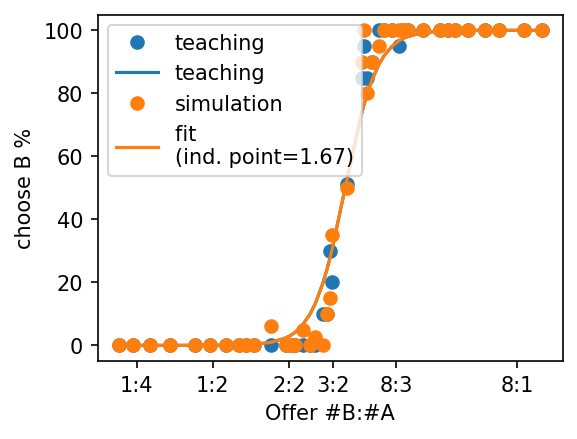

In [19]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


dirPath = '/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/juiceTaskDefault/juiceTaskDefault_20231204-14-12_10_notFail'
dirPath = '/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/orderTaskDefault/orderTaskDefault_20231204-14-12_0_notFail'
dirPathJuice = '/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/juiceTaskDefault/juiceTaskDefault_20231204-12-12_3_'
dirPathOrder = '/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/orderTaskDefault/orderTaskDefault_20231204-15-12_5_'
dirPath = dirPathJuice

x,trial_params,model_state,choice12,choiceB,choiceLR,qAs,qBs,seqAB,choiceFrame = importAndPreprocess(dirPath,'activitityTestGrid.npz')

epsilon = 1e-4
model = regreessBehavior(choiceB,qAs,qBs,seqAB)
a0,(a1,a2) = model.intercept_[0], model.coef_[0]

fig  = plotBehavior(qAs,qBs,trial_params,choiceB, seqAB)
fig.set_size_inches((4,3))
fig.set_dpi(150)

fig.savefig('/gpfsnyu/scratch/jtg374/psychrnn/Figure/behOrder.pdf')

In [18]:
a0,a1,a2

(-3.5628529677492904, 6.925688365942593, 0.2222599102060072)

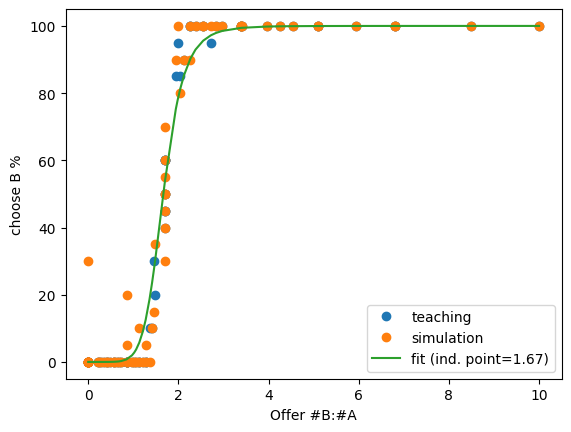

In [19]:
import numpy as np
class LogitRegression() : 
    def __init__( self, learning_rate=0.1, iterations=5000,verbose=False ) :         
        self.learning_rate = learning_rate         
        self.iterations = iterations 
        self.verbose  = verbose
          
    # Function for model training     
    def fit( self, X, Y ) :         
        # no_of_training_examples, no_of_features         
        self.m, self.n = X.shape         
        # weight initialization         
        self.W = np.zeros( self.n )         
        self.b = 0.0        
        self.X = X
        if not np.isin(Y,[0,1]).all(): 
            raise ValueError('elements of Y must be in set {0,1}')         
        self.Y = Y 
          
        # gradient descent learning 
                  
        for i in range( self.iterations ) :             
            self.update_weights()
            if self.verbose: print(i, self.cost_func())             
        return self
    
    # gradient decent    
    def update_weights(self):
        H = self.sigmoid(self.X.dot(self.W) + self.b)
        dW,db = self.cost_grad(H)
        self.W = self.W - self.learning_rate * dW     
        self.b = self.b - self.learning_rate * db 
          
        return self    

    #cost function
    def cost_func(self):
        H = self.sigmoid(self.X.dot(self.W) + self.b)
        epsilon = 1e-5
        cost = - ( np.dot(self.Y,np.log(H)) + np.dot(1-self.Y, np.log(1-H)) ) / (self.m)
        return cost
    
    # gradient of cost function
    def cost_grad(self,H):
        tmp = H.reshape(-1) - self.Y
        dW = self.X.T @ tmp / self.m
        db = tmp.mean() 
        return dW,db
    
    def sigmoid(self,x):
        return 1 / (1 + np.exp(-x))        


def regreessBehavior(choiceB,qAs,qBs,seqAB):
    idx=(qAs!=0)&(qBs!=0)
    X = np.vstack((np.log(qBs[idx]/qAs[idx]),seqAB[idx])).T
    y = choiceB[idx]
    model = LogitRegression(learning_rate=0.1,iterations=5000,verbose=False)
    model.fit(X,y)
    return model
    # return model.intercept_[0], model.coef_[0]
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def plotBehavior(qAs,qBs,trial_params,choiceB,seqAB):

    model = regreessBehavior(choiceB,qAs,qBs,seqAB)
    a0,(a1,a2) = model.b, model.W

    offerRatio = (qBs+1e-4)/(qAs+1e-4)
    offerRatio[(qAs==0)&(qBs==0)]=np.nan
    offerRatio[offerRatio>10] = 10
    ChoiceTarget =  np.array([trial_params[i]['chooseB'] for i in range(len(trial_params))])

    oRs = np.unique(offerRatio[~np.isnan(offerRatio)])
    cu = np.zeros(oRs.shape)
    cc = np.zeros(oRs.shape)
    
    fitChoice = sigmoid(a0+a1*np.log(oRs))*100

    for ii,oR in enumerate(oRs):
        cu[ii] = np.mean(choiceB[offerRatio==oR])
        cc[ii] = np.mean(ChoiceTarget[offerRatio==oR])
    fig1, ax = plt.subplots()
    ax.plot(oRs,cc*100,'o',label='teaching')
    ax.plot(oRs,cu*100,'o',label='simulation')
    ax.plot(oRs, fitChoice, label=f'fit (ind. point={np.exp(-a0/a1):.2f})')
    ax.legend()
    ax.set_xlabel('Offer #B:#A')
    ax.set_ylabel('choose B %')

    return fig1


model = regreessBehavior(choiceB,qAs,qBs,seqAB)

a0,(a1,a2) = model.b, model.W

_  = plotBehavior(qAs,qBs,trial_params,choiceB, seqAB)